In [1]:
import os
os.chdir('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/notebooks/TEST_FINALS/')
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
from jax import vmap, grad
from jax_cosmo import Cosmology
from functools import partial
from jax_cosmo.power import linear_matter_power
from jax_cosmo.background import angular_diameter_distance, radial_comoving_distance
import jax_cosmo.transfer as tklib
import astropy.units as u
from astropy import constants as const
RHO_CRIT_0_MPC3 = 2.77536627245708E11
G_new = ((const.G * (u.M_sun / u.Mpc**3) * (u.M_sun) / (u.Mpc)).to(u.eV / u.cm**3)).value
import constants
import jax_cosmo.background as bkgrd
import jax_cosmo.transfer as tklib
from jax_cosmo.scipy.integrate import romb
from jax_cosmo.scipy.integrate import simps
from jax_cosmo.scipy.interpolate import interp
from mcfit import xi2P
from colossus.halo import mass_so
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
class HMF_jax:
    def __init__(
                self,
                sim_params_dict,
                halo_params_dict,
                num_points_trapz_int=64
            ):    
        
        self.cosmo_params = sim_params_dict['cosmo']

        self.cosmo_jax = Cosmology(
            Omega_c=self.cosmo_params['Om0'] - self.cosmo_params['Ob0'],
            Omega_b=self.cosmo_params['Ob0'],
            h=self.cosmo_params['H0'] / 100.,
            sigma8=self.cosmo_params['sigma8'],
            n_s=self.cosmo_params['ns'],
            Omega_k=0.,
            w0=self.cosmo_params['w0'],
            wa=0.
            )

        zmin, zmax, nz = halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz']
        Mmin, Mmax, nM = halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM']
        dmin, dmax, nd = halo_params_dict['dmin'], halo_params_dict['dmax'], halo_params_dict['nd']
        self.Rcond = halo_params_dict['Rcond']
        self.z_array = jnp.linspace(zmin, zmax, nz)
        self.M_array = jnp.logspace(np.log10(Mmin), np.log10(Mmax), nM)
        self.deltam_array = jnp.exp(jnp.linspace(jnp.log(1+dmin+1e-3), jnp.log(1+dmax+1e-3), nd)) - 1.0
        mdef = halo_params_dict['mdef']
        r200c_mat = np.zeros((len(self.M_array), len(self.z_array)))
        for jz in range(len(self.z_array)):
            r200c_mat[:, jz] = (mass_so.M_to_R(self.M_array, self.z_array[jz], mdef) / (1000.))

        self.r200c_mat = jnp.array(r200c_mat)

        self.scale_fac_a_array = 1./(1. + self.z_array)
        self.nM, self.nz, self.nd = len(self.M_array), len(self.z_array), len(self.deltam_array)

        if 'pklin_kz_mat' in sim_params_dict.keys():
            self.kPk_array = sim_params_dict['kPk_array']
            self.plin_kz_mat = sim_params_dict['pklin_kz_mat']
        else:
            self.kPk_array = jnp.logspace(jnp.log10(1E-3), jnp.log10(100), 100)
            self.plin_kz_mat = vmap(linear_matter_power,(None, None, 0))(self.cosmo_jax, self.kPk_array, self.scale_fac_a_array).T

        rhom_z_array = (constants.RHO_CRIT_0_KPC3 * self.cosmo_params['Om0'] * (1.0 + self.z_array)**3) * 1E9
        rhom_z_mat = jnp.repeat(rhom_z_array[:, None], self.nM, axis=1)
        M_z_mat = jnp.repeat(self.M_array[None,:], self.nz, axis=0)

        rhom_z_delta_mat = jnp.repeat(rhom_z_mat[:,:, None], self.nd, axis=2)
        M_z_delta_mat = jnp.repeat(M_z_mat[:,:, None], self.nd, axis=2)


        vmap_func1 = vmap(self.get_lgsigma_z, (0, None))
        vmap_func2 = vmap(vmap_func1, (None, 0))
        lgsigma_Mz_mat = vmap_func2(self.z_array, jnp.log(self.M_array)).T
        self.sigma_Mz_mat = jnp.exp(lgsigma_Mz_mat)

        grad_lgsigma = grad(self.get_lgsigma_z, argnums=1)
        vmap_func1 = vmap(grad_lgsigma, (0, None))
        vmap_func2 = vmap(vmap_func1, (None, 0))
        self.dlgsig_dlnM_mat = vmap_func2(self.z_array, jnp.log(self.M_array)).T

        vmap_func1 = vmap(self.get_fsigma_Mz, (0, None))
        vmap_func2 = vmap(vmap_func1, (None, 0))
        self.fsigma_Mz_mat = vmap_func2(jnp.arange(self.nz), jnp.arange(self.nM)).T

        self.hmf_Mz_mat = -1 * self.fsigma_Mz_mat * (rhom_z_mat/M_z_mat) * self.dlgsig_dlnM_mat


        vmap_func1 = vmap(self.get_lgsigmaprime_z, (0, None, None))
        vmap_func2 = vmap(vmap_func1, (None, 0, None))
        vmap_func3 = vmap(vmap_func2, (None, None, 0))        
        lgsigma_Mzdeltam_mat = vmap_func3(self.z_array, jnp.log(self.M_array), self.deltam_array).T
        self.sigma_Mzdeltam_mat = jnp.exp(lgsigma_Mzdeltam_mat)

        # grad_lgsigmadeltam = grad(self.get_lgsigmaprime_z, argnums=1)
        # vmap_func1 = vmap(grad_lgsigmadeltam, (0, None, None))
        # vmap_func2 = vmap(vmap_func1, (None, 0, None))
        # vmap_func3 = vmap(vmap_func2, (None, None, 0))        
        # self.dlgsig_dlnM_deltam_mat = vmap_func3(self.z_array, jnp.log(self.M_array), self.deltam_array).T
        self.dlgsig_dlnM_deltam_mat = jnp.repeat(self.dlgsig_dlnM_mat[:,:, None], self.nd, axis=2)

        vmap_func1 = vmap(self.get_fsigma_Mzdeltam, (0, None, None))
        vmap_func2 = vmap(vmap_func1, (None, 0, None))
        vmap_func3 = vmap(vmap_func2, (None, None, 0))        
        self.fsigma_Mzdeltam_mat = vmap_func3(jnp.arange(self.nz), jnp.arange(self.nM), jnp.arange(self.nd)).T

        self.hmf_Mzdeltam_mat = -1 * self.fsigma_Mzdeltam_mat * (rhom_z_delta_mat/M_z_delta_mat) * self.dlgsig_dlnM_deltam_mat


        
    def get_rho_m(self, z):
        return (constants.RHO_CRIT_0_KPC3 * self.cosmo_params['Om0'] * (1.0 + z)**3) * 1E9

    def get_Ez(self, z):
        zp1 = (1.0 + z)
        t = (self.cosmo_params['Om0']) * zp1**3 + (1 - self.cosmo_params['Om0'])
        E = jnp.sqrt(t)        
        return E

    def get_rho_c(self, z):
        return constants.RHO_CRIT_0_KPC3 * self.get_Ez(z)**2  * 1E9      

    @partial(jit, static_argnums=(0,))        
    def get_lgsigma_z(self, z, lgM, kmin=0.0001, kmax=1000.0):
        M = jnp.exp(lgM)
        R = (3.0 * M / 4.0 / jnp.pi / self.get_rho_m(0.0))**(1.0 / 3.0)

        jz = jnp.searchsorted(self.z_array, z)

        def int_sigma(logk):
            k = jnp.exp(logk)
            x = k * R
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        return jnp.log(jnp.sqrt(y / (2.0 * jnp.pi**2.0)))
        
    @partial(jit, static_argnums=(0,))        
    def get_lgsigma_l_z(self, z, lgM, kmin=0.0001, kmax=1000.0):
        M = jnp.exp(lgM)
        R = (3.0 * M / 4.0 / jnp.pi / self.get_rho_m(0.0))**(1.0 / 3.0)

        jz = jnp.searchsorted(self.z_array, z)

        def int_sigma(logk):
            k = jnp.exp(logk)
            x = k * self.Rcond
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        return jnp.log(jnp.sqrt(y / (2.0 * jnp.pi**2.0)))


    @partial(jit, static_argnums=(0,))        
    def get_lgsigmaprime_z(self, z, lgM, delta_m, kmin=0.0001, kmax=1000.0):

        jz = jnp.searchsorted(self.z_array, z) 

        M = jnp.exp(lgM)
        R_M = (3.0 * M / 4.0 / jnp.pi / self.get_rho_m(0.0))**(1.0 / 3.0)
        def int_sigma_M(logk):
            k = jnp.exp(logk)
            x = k * R_M
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma_M, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        sigma_sqr = jnp.sqrt(y / (2.0 * jnp.pi**2.0))

        def int_sigma_cond(logk):
            k = jnp.exp(logk)
            x = k * self.Rcond * (1 + delta_m)**(1/3.)
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma_cond, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        sigma_l_sqr = jnp.sqrt(y / (2.0 * jnp.pi**2.0))

        sigma_prime_sqr = (sigma_sqr - sigma_l_sqr)

        return jnp.log(jnp.sqrt(sigma_prime_sqr))

    @partial(jit, static_argnums=(0,))
    def get_fsigma_Mz(self, jz, jM, mdef_delta=200):
        '''Tinker 2008 mass function'''
        sigma = self.sigma_Mz_mat[jz, jM]

        delta_c = constants.DELTA_COLLAPSE
        A = 0.3222
        a = 0.707
        p = 0.3
        
        nu_p = a * delta_c**2 / sigma**2
        f = A * jnp.sqrt(nu_p * 2.0 / jnp.pi) * jnp.exp(-0.5 * nu_p) * (1.0 + nu_p**-p)        
        
        return f


    @partial(jit, static_argnums=(0,))
    def get_fsigma_Mzdeltam(self, jz, jM, jd, mdef_delta=200):
        '''Tinker 2008 mass function'''
        sigma = self.sigma_Mzdeltam_mat[jz, jM, jd]
        delta_m = self.deltam_array[jd]
        delta_l = (constants.DELTA_COLLAPSE/1.68647) * (1.68647 - (1.35/((1 + delta_m)**(2/3))) - 1.12431/((1 + delta_m)**(0.5)) + 0.78785/((1 + delta_m)**0.58661))        
        delta_c = constants.DELTA_COLLAPSE - delta_l
        A = 0.3222
        a = 0.707
        p = 0.3
        
        nu_p = a * delta_c**2 / sigma**2
        f = A * jnp.sqrt(nu_p * 2.0 / jnp.pi) * jnp.exp(-0.5 * nu_p) * (1.0 + nu_p**-p)        

        
        return f





In [64]:
import pickle as pk
ns_h = 256
sdir='/pscratch/sd/s/spandey/quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(0) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

nside_h = ns_h
nbatch = 8
nfilter = 3
ji = 0
df_load = pk.load(open(
    sdir + '/' + str(ji) + '/density_subvol_m_res_' + str(nside_h) + '_z=' + str(0) + '_nbatch_' + str(nbatch) + '_nfilter_' + str(nfilter) + '_ncnn_' + str(0) + '.pk', 'rb')
    )

df_d0 = df_load['density_cic_pad']

R_sph = (1024/ns_h) * (3/(4*np.pi))**(1/3.)


In [65]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['cosmo'] = cosmo_params_dict



halo_params_dict = {}
halo_params_dict['dmin'], halo_params_dict['dmax'], halo_params_dict['nd'] = -1.0, 100, 64
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0, 0.5, 2
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e13, 1e16, 256
halo_params_dict['mdef'] = '200c'
halo_params_dict['Rcond'] = R_sph*1.5

cosmo_jax = Cosmology(
    Omega_c=cosmo_params_dict['Om0'] - cosmo_params_dict['Ob0'],
    Omega_b=cosmo_params_dict['Ob0'],
    h=cosmo_params_dict['H0'] / 100.,
    sigma8=cosmo_params_dict['sigma8'],
    n_s=cosmo_params_dict['ns'],
    Omega_k=0.,
    w0=cosmo_params_dict['w0'],
    wa=0.
    )

zmin, zmax, nz = halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz']
z_array = jnp.linspace(zmin, zmax, nz)
scale_fac_a_array = 1./(1. + z_array)

kPk_array = jnp.logspace(jnp.log10(1E-3), jnp.log10(100), 100)
plin_kz_mat = vmap(linear_matter_power,(None, None, 0))(cosmo_jax, kPk_array, scale_fac_a_array).T

sim_params_dict['kPk_array'] = kPk_array
sim_params_dict['plin_kz_mat'] = plin_kz_mat


In [66]:
%%time
HMF_jax_test = HMF_jax(sim_params_dict, halo_params_dict)





CPU times: user 29.9 s, sys: 2.26 s, total: 32.1 s
Wall time: 10.2 s


In [67]:
dndm_jax = HMF_jax_test.hmf_Mz_mat
dndm_cond_jax = HMF_jax_test.hmf_Mzdeltam_mat





In [68]:
# len(indsel)




In [69]:
dmin = 10.0
dmax = 20.0
dmean = (dmin+dmax)/2.0
indsel = np.where((df_d0 > dmin) & (df_d0 < dmax))

df_Mh_all_truth_deltam = df_Mh_all_truth[indsel[0],indsel[1],indsel[2],indsel[3],:].flatten()


bin_cents = np.linspace(13.3, 16.0, 64)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
# pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
delta_logM = bin_edges[1:] - bin_edges[:-1]
dndlogm_truth = hist_truth/(1e9*delta_b)



Text(0, 0.5, 'Histogram')

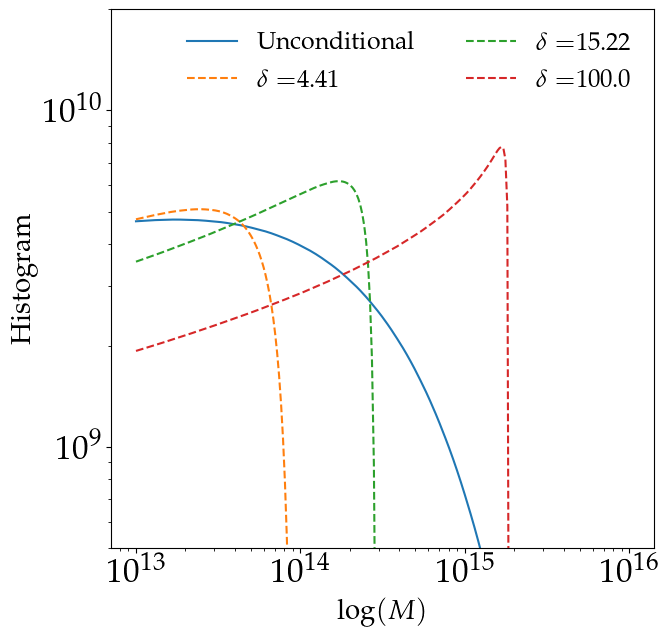

In [87]:
# dndm_jax.shape
pl.figure()
pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_jax[0,:],label='Unconditional')
# pl.errorbar(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='', marker='s', color='k', label='Truth')
pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,ind_delta-6], ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta-6], 2)))
pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,ind_delta], ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta], 2)))
pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,ind_delta+10], ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta+10], 2)))
# pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,13], ls='-.')
pl.legend(fontsize=18, frameon=False, ncol=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(5e8, 2e10)
pl.xlabel(r'$\log(M)$', fontsize=20)
pl.ylabel(r'Histogram', fontsize=20)


Text(0, 0.5, 'Histogram')

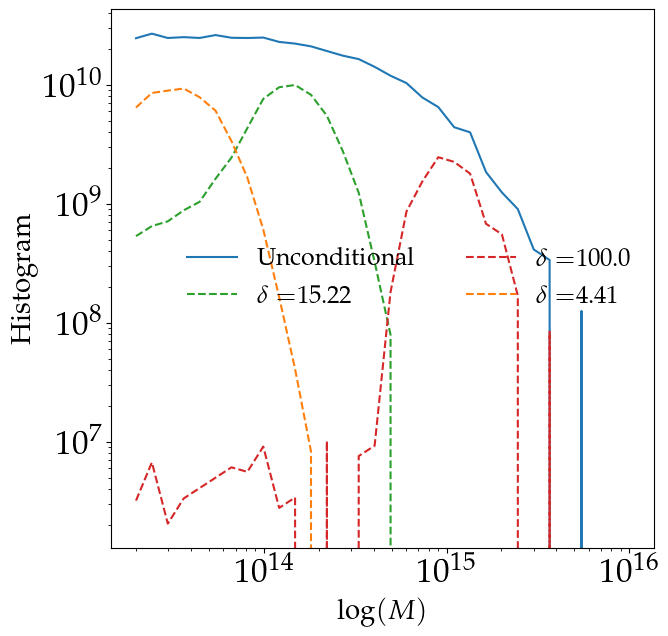

In [90]:
# dmin = 10.0
# dmax = 20.0
# dmean = (dmin+dmax)/2.0
bin_cents = np.linspace(13.3, 16.0, 32)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)
delta_logM = bin_edges[1:] - bin_edges[:-1]





# dndm_jax.shape
pl.figure()

df_Mh_all_truth_deltam = df_Mh_all_truth.flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.plot(10**bin_cents, (10**bin_cents)*dndlogm_truth,label='Unconditional')

indsel = np.where((df_d0 > HMF_jax_test.deltam_array[ind_delta-7]) & (df_d0 < HMF_jax_test.deltam_array[ind_delta-5]))
df_Mh_all_truth_deltam = df_Mh_all_truth[indsel[0],indsel[1],indsel[2],indsel[3],:].flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.errorbar(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta-6], 2)))


indsel = np.where((df_d0 > HMF_jax_test.deltam_array[ind_delta-1]) & (df_d0 < HMF_jax_test.deltam_array[ind_delta+1]))
df_Mh_all_truth_deltam = df_Mh_all_truth[indsel[0],indsel[1],indsel[2],indsel[3],:].flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.plot(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta], 2)))

indsel = np.where((df_d0 > HMF_jax_test.deltam_array[ind_delta+8]) & (df_d0 < HMF_jax_test.deltam_array[ind_delta+12]))
df_Mh_all_truth_deltam = df_Mh_all_truth[indsel[0],indsel[1],indsel[2],indsel[3],:].flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.plot(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta+10], 2)))
# pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,13], ls='-.')
pl.legend(fontsize=18, frameon=False, ncol=2)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(5e8, 2e10)
pl.xlabel(r'$\log(M)$', fontsize=20)
pl.ylabel(r'Histogram', fontsize=20)



Text(0, 0.5, 'Histogram')

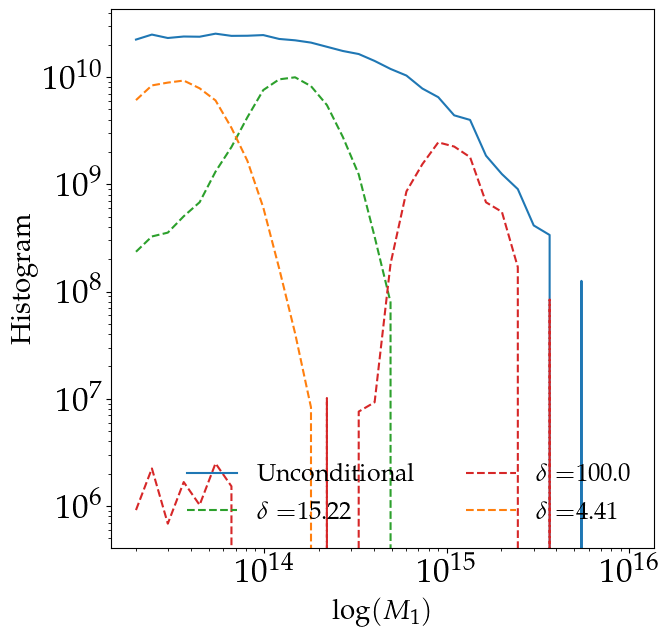

In [91]:
# dmin = 10.0
# dmax = 20.0
# dmean = (dmin+dmax)/2.0
bin_cents = np.linspace(13.3, 16.0, 32)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)
delta_logM = bin_edges[1:] - bin_edges[:-1]





# dndm_jax.shape
pl.figure()

df_Mh_all_truth_deltam = df_Mh_all_truth[...,0].flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.plot(10**bin_cents, (10**bin_cents)*dndlogm_truth,label='Unconditional')

indsel = np.where((df_d0 > HMF_jax_test.deltam_array[ind_delta-7]) & (df_d0 < HMF_jax_test.deltam_array[ind_delta-5]))
df_Mh_all_truth_deltam = df_Mh_all_truth[indsel[0],indsel[1],indsel[2],indsel[3],0].flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.errorbar(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta-6], 2)))


indsel = np.where((df_d0 > HMF_jax_test.deltam_array[ind_delta-1]) & (df_d0 < HMF_jax_test.deltam_array[ind_delta+1]))
df_Mh_all_truth_deltam = df_Mh_all_truth[indsel[0],indsel[1],indsel[2],indsel[3],0].flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.plot(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta], 2)))

indsel = np.where((df_d0 > HMF_jax_test.deltam_array[ind_delta+8]) & (df_d0 < HMF_jax_test.deltam_array[ind_delta+12]))
df_Mh_all_truth_deltam = df_Mh_all_truth[indsel[0],indsel[1],indsel[2],indsel[3],0].flatten()
hist_truth, _ = np.histogram(df_Mh_all_truth_deltam, bins=bin_edges)
dndlogm_truth = hist_truth/(1e9*delta_b)
pl.plot(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='--', label=r'$\delta=$' + str(np.round(HMF_jax_test.deltam_array[ind_delta+10], 2)))
# pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,13], ls='-.')
pl.legend(fontsize=18, frameon=False, ncol=2)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(5e8, 2e10)
pl.xlabel(r'$\log(M_1)$', fontsize=20)
pl.ylabel(r'Histogram', fontsize=20)



(1000.0, 1000000000000.0)

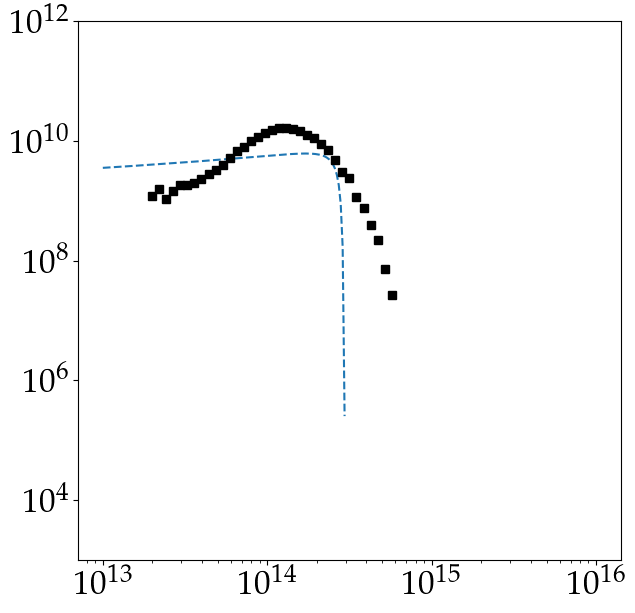

In [71]:
# dndm_jax.shape
pl.figure()
# pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_jax[0,:])
pl.errorbar(10**bin_cents, (10**bin_cents)*dndlogm_truth, ls='', marker='s', color='k', label='Truth')
pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,ind_delta], ls='--')
# pl.plot(HMF_jax_test.M_array, HMF_jax_test.M_array*dndm_cond_jax[0,:,13], ls='-.')
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e3, 1e12)




In [14]:
# (10**bin_cents)
# hist_truth

In [16]:
# dndm_cond_jax[0,:,5]
HMF_jax_test.deltam_array[12]

Array(9.08000016, dtype=float64)

In [80]:
sigmaMz_jax = HMF_jax_test.sigma_Mz_mat
sigmaMz_cond_jax = HMF_jax_test.sigma_Mzdeltam_mat





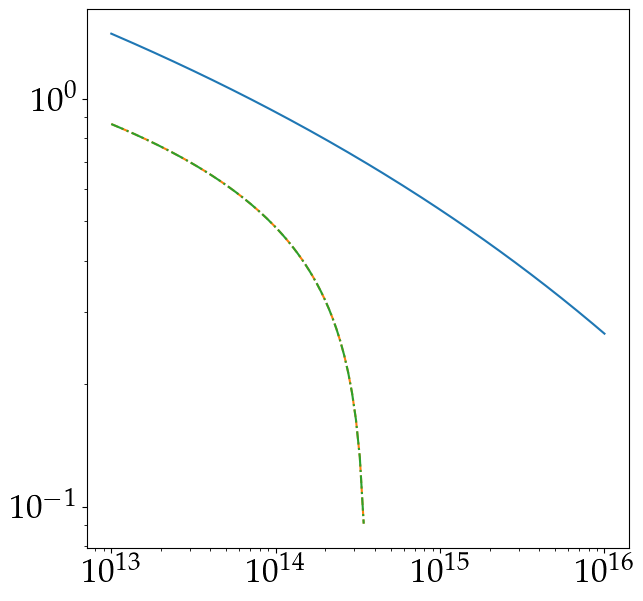

In [81]:
# dndm_jax.shape
pl.figure()
pl.plot(HMF_jax_test.M_array, sigmaMz_jax[0,:])
pl.plot(HMF_jax_test.M_array, sigmaMz_cond_jax[0,:,10], ls='--')
pl.plot(HMF_jax_test.M_array, sigmaMz_cond_jax[0,:,15], ls='-.')
pl.xscale('log')
pl.yscale('log')





In [83]:
sigmaMz_cond_jax[0,:,15]

Array([0.86613821, 0.85825413, 0.85033554, 0.84237994, 0.83438844,
       0.82636116, 0.81829734, 0.8101962 , 0.80205334, 0.79386572,
       0.78563459, 0.77736003, 0.76904217, 0.76068057, 0.75227062,
       0.74380874, 0.73529564, 0.72673082, 0.71811282, 0.70944024,
       0.70070716, 0.69190907, 0.68304611, 0.67411788, 0.66512316,
       0.65606083, 0.64692428, 0.63770769, 0.62841027, 0.61903033,
       0.60956426, 0.6000091 , 0.59035585, 0.58059652, 0.57072871,
       0.56074957, 0.55065465, 0.54043984, 0.53009368, 0.51960459,
       0.508967  , 0.49817396, 0.48721554, 0.47608178, 0.46475425,
       0.4532138 , 0.44144737, 0.42944041, 0.41717428, 0.40462884,
       0.39177145, 0.37856431, 0.36497374, 0.35095938, 0.33646879,
       0.32144015, 0.30578581, 0.28939575, 0.27214259, 0.2538579 ,
       0.23430409, 0.21313928, 0.18981447, 0.16339106, 0.13203249,
       0.09077826,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        